## Getting Started

In [16]:
# Check whether runtime is connected
print("Hello world!")

Hello world!


In [17]:
# General imports
import os
import joblib
import random
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Models
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model evaluation
from sklearn.metrics import classification_report

In [18]:
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [19]:
fert_df = pd.read_csv("../data/fertilizer_dataset.csv")

fert_df.head(10)

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Soil,Crop,Fertilizer,Remark
0,50.179845,0.725893,205.600816,6.227358,66.701872,76.963560,96.429065,0.496300,Loamy Soil,rice,Compost,Enhances organic matter and improves soil stru...
1,21.633318,0.721958,306.081601,7.173131,71.583316,163.057636,148.128347,1.234242,Loamy Soil,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru..."
2,23.060964,0.685751,259.336414,7.380793,75.709830,62.091508,80.308971,1.795650,Peaty Soil,rice,Water Retaining Fertilizer,Improves water retention in dry soils. Prefer ...
3,26.241975,0.755095,212.703513,6.883367,78.033687,151.012521,153.005712,1.517556,Loamy Soil,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru..."
4,21.490157,0.730672,268.786767,7.578760,71.765123,66.257371,97.000886,1.782985,Peaty Soil,rice,Organic Fertilizer,"Enhances fertility naturally, ideal for peaty ..."
5,50.179845,0.227436,275.544796,8.828433,74.990641,128.631682,129.099985,0.843296,Loamy Soil,rice,Gypsum,"Corrects alkaline soil, adds calcium and sulfu..."
6,22.386834,0.227436,292.745108,5.902666,78.814989,60.471726,66.060843,1.518379,Peaty Soil,rice,Lime,Neutralizes acidic soil and improves pH balanc...
7,21.342227,0.785753,249.980185,5.692240,72.089121,42.591255,68.035609,2.410625,Peaty Soil,rice,DAP,"Rich in phosphorus, essential for root develop..."
8,25.657999,0.756739,250.701012,6.614611,75.032505,118.005348,142.004742,-0.280560,Loamy Soil,rice,Compost,Enhances organic matter and improves soil stru...
9,21.296925,0.783450,211.049382,6.386646,72.711484,68.352057,94.695401,2.464714,Peaty Soil,rice,Organic Fertilizer,"Enhances fertility naturally, ideal for peaty ..."


In [20]:
crop_df = pd.read_csv("../data/crop.csv")

crop_df.head(10)

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
5,69,37,42,23.058049,83.370118,7.073454,251.055000,rice
6,69,55,38,22.708838,82.639414,5.700806,271.324860,rice
7,94,53,40,20.277744,82.894086,5.718627,241.974195,rice
8,89,54,38,24.515881,83.535216,6.685346,230.446236,rice
9,68,58,38,23.223974,83.033227,6.336254,221.209196,rice


## EDA

### Fertilizer Recommendation Dataset

In [21]:
fert_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3100 entries, 0 to 3099
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  3100 non-null   float64
 1   Moisture     3100 non-null   float64
 2   Rainfall     3100 non-null   float64
 3   PH           3100 non-null   float64
 4   Nitrogen     3100 non-null   float64
 5   Phosphorous  3100 non-null   float64
 6   Potassium    3100 non-null   float64
 7   Carbon       3100 non-null   float64
 8   Soil         3100 non-null   object 
 9   Crop         3100 non-null   object 
 10  Fertilizer   3100 non-null   object 
 11  Remark       3100 non-null   object 
dtypes: float64(8), object(4)
memory usage: 290.8+ KB


In [22]:
fert_df.describe()

,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon
count,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000
mean,27.271096,0.600763,111.024949,6.379775,61.278480,69.582850,69.721167,1.474325
std,9.114450,0.144947,77.151880,0.957103,10.186410,42.226712,35.304241,0.698300
min,4.011486,0.227436,-85.709593,3.448974,35.527718,-37.649739,-20.509108,-0.280560
25%,22.408505,0.493595,61.283985,5.860489,54.835715,43.039260,49.992405,0.956401
50%,26.132938,0.599520,96.485935,6.337308,59.429649,58.205269,58.710808,1.463357
75%,29.987887,0.708575,147.619401,6.899739,65.792790,86.108983,76.318626,2.003534
max,56.653592,0.972361,411.955947,9.562341,98.581039,177.314481,161.067982,3.241984


In [23]:
fert_df.select_dtypes("object").nunique()

Soil           5
Crop          31
Fertilizer    10
Remark        10
dtype: int64

In [24]:
fert_df['Crop'].value_counts()

Crop
rice            100
wheat           100
Mung Bean       100
Tea             100
millet          100
maize           100
Lentil          100
Jute            100
Coffee          100
Cotton          100
Ground Nut      100
Peas            100
Rubber          100
Sugarcane       100
Tobacco         100
Kidney Beans    100
Moth Beans      100
Coconut         100
Black gram      100
Adzuki Beans    100
Pigeon Peas     100
Chickpea        100
banana          100
grapes          100
apple           100
mango           100
muskmelon       100
orange          100
papaya          100
pomegranate     100
watermelon      100
Name: count, dtype: int64

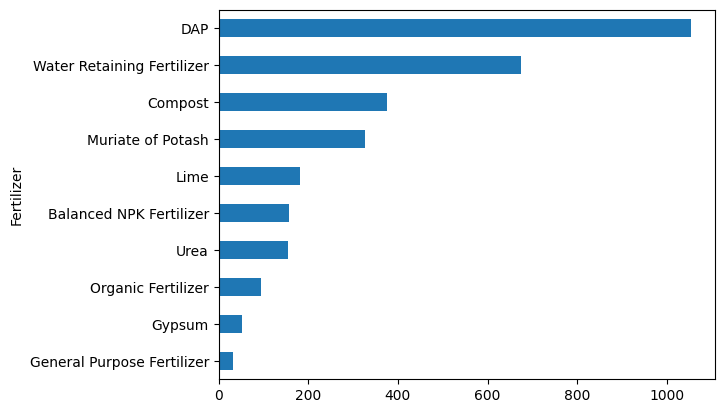

In [25]:
fert_df["Fertilizer"].value_counts().sort_values().plot(kind="barh")
plt.show()

In [26]:
# Convert all crop names to lowercase and get unique values from both dataframes
fert_crops = set(fert_df["Crop"].str.lower().unique())
crop_labels = set(crop_df["label"].str.lower().unique())

# Find intersection (matching crops)
matching_crops = fert_crops.intersection(crop_labels)

# Convert back to a sorted list if needed
matching_crops = sorted(list(matching_crops))

print("Matching crops:")
print(matching_crops)

# If you want the count:
print(f"\nTotal matching crops: {len(matching_crops)}")

Matching crops:
['apple', 'banana', 'chickpea', 'coconut', 'coffee', 'cotton', 'grapes', 'jute', 'lentil', 'maize', 'mango', 'muskmelon', 'orange', 'papaya', 'pomegranate', 'rice', 'watermelon']

Total matching crops: 17


### Crop Recommendation Dataset

In [27]:
crop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [28]:
crop_df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


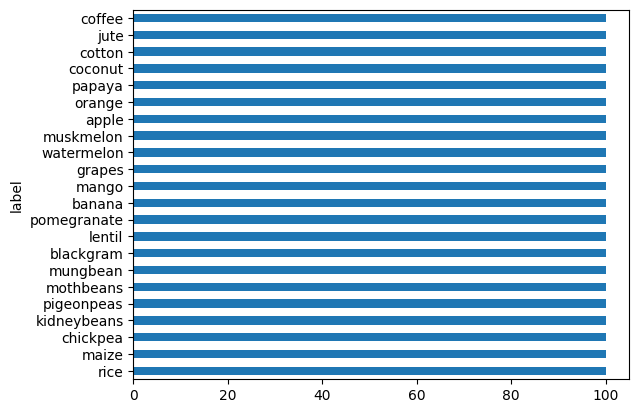

In [29]:
crop_df["label"].value_counts().sort_values().plot(kind="barh")
plt.show()

There is no class imbalance in the crop recommendation dataset.

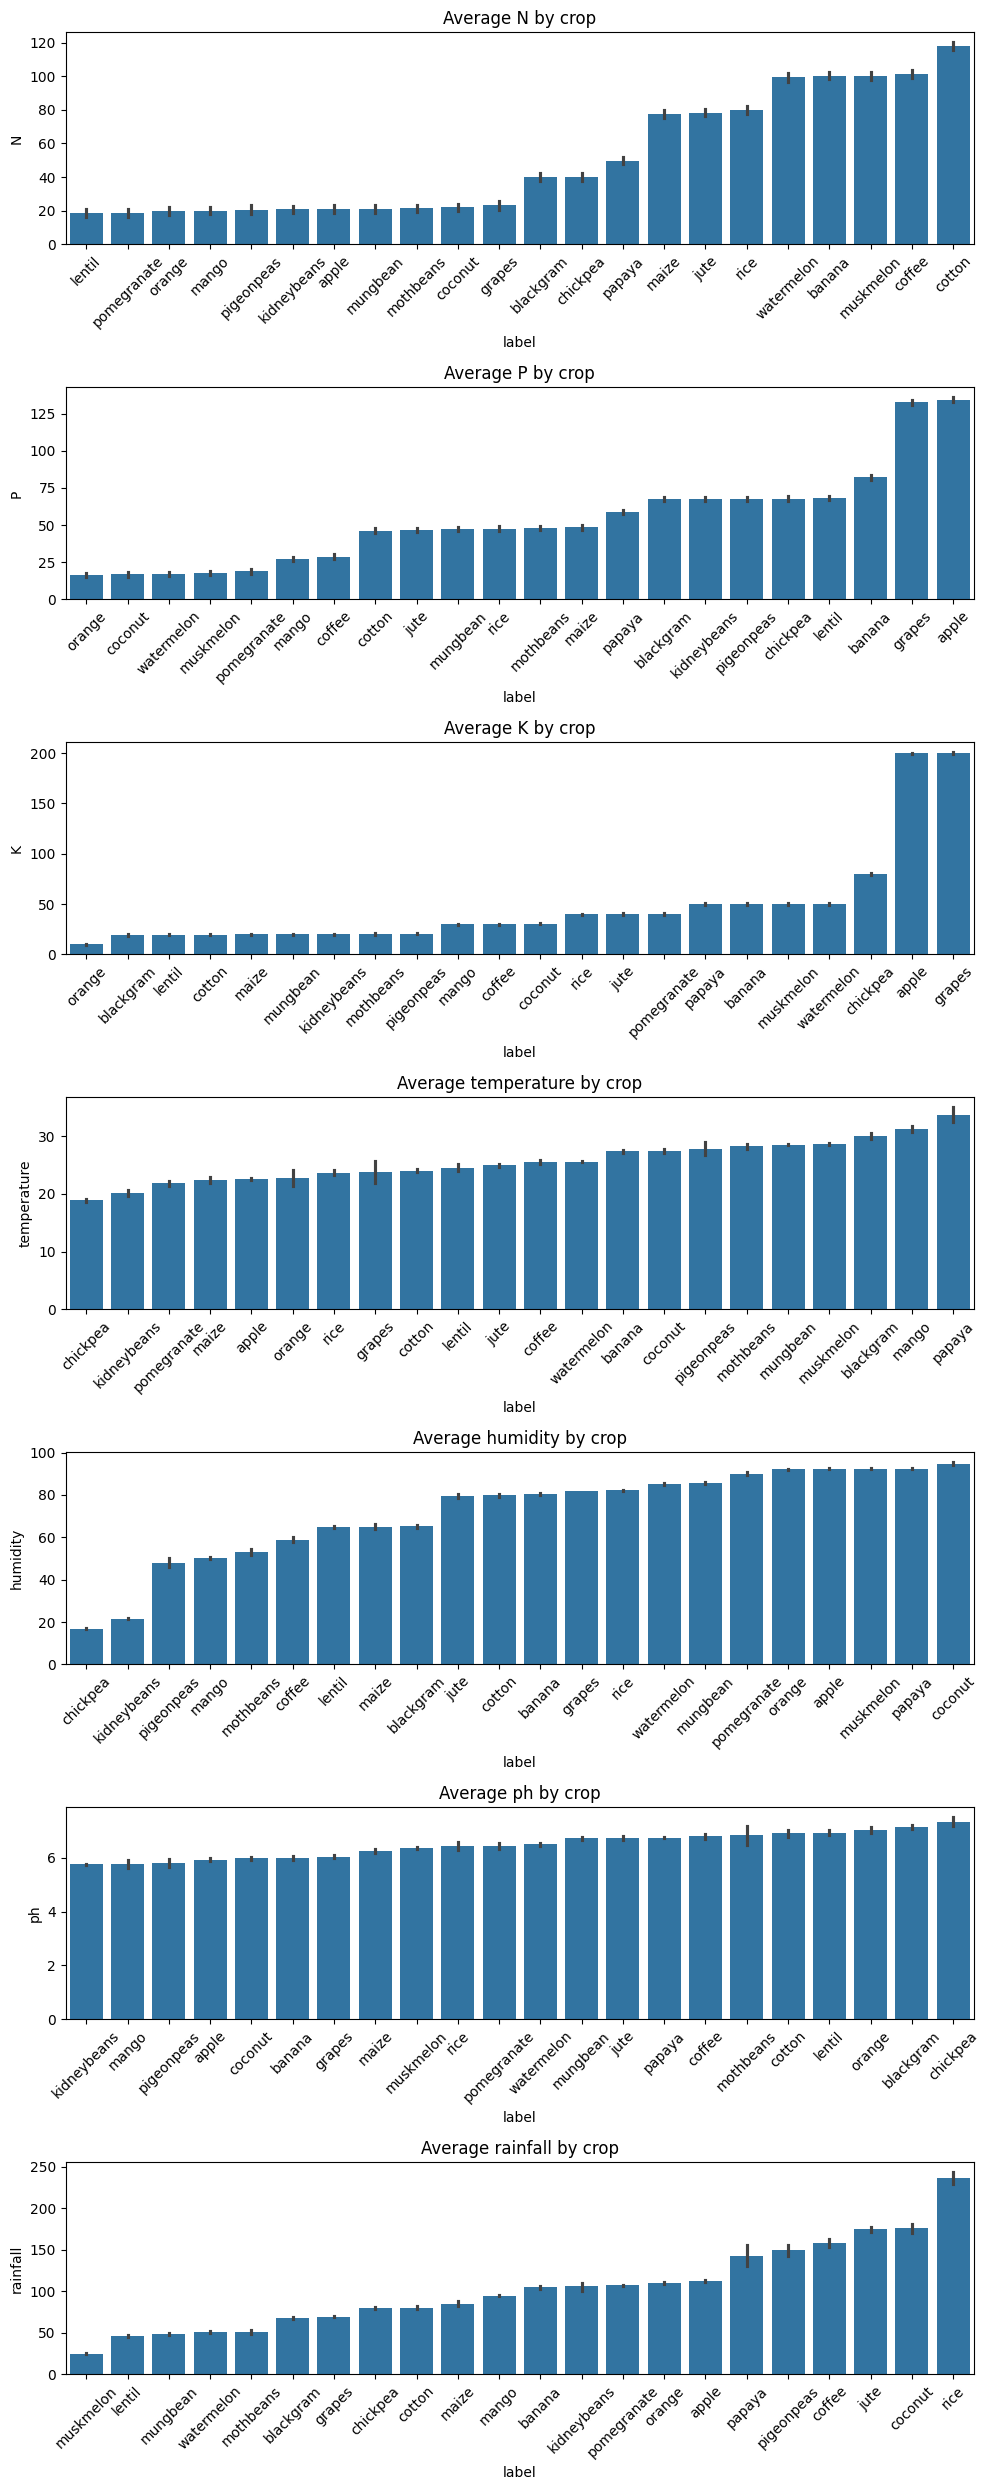

In [30]:
features = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]

plt.figure(figsize=(10, 25))
for i, feature in enumerate(features, 1):
    plt.subplot(len(features), 1, i)
    sns.barplot(
        x="label",
        y=feature,
        data=crop_df,
        estimator="mean",
        order=crop_df.groupby("label")[feature].mean().sort_values().index,
    )
    plt.title(f"Average {feature} by crop")
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

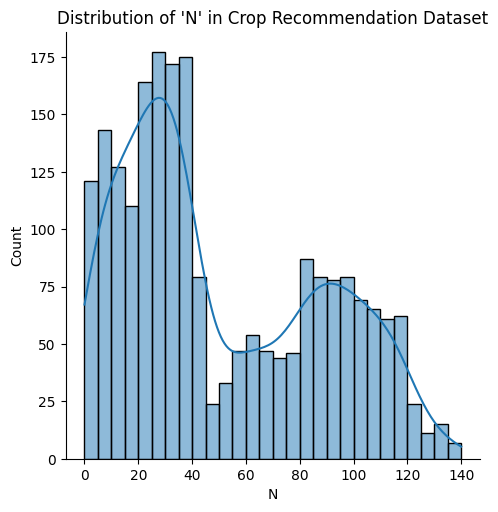

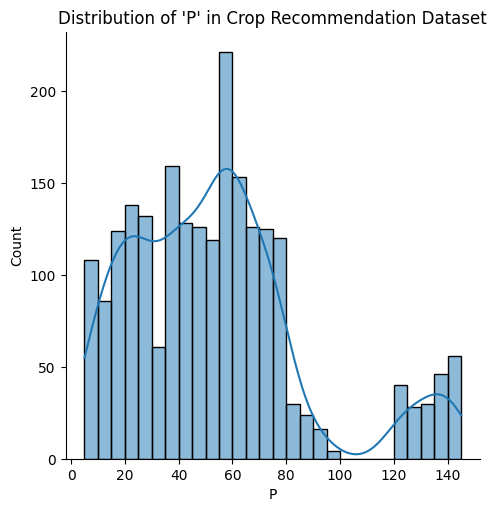

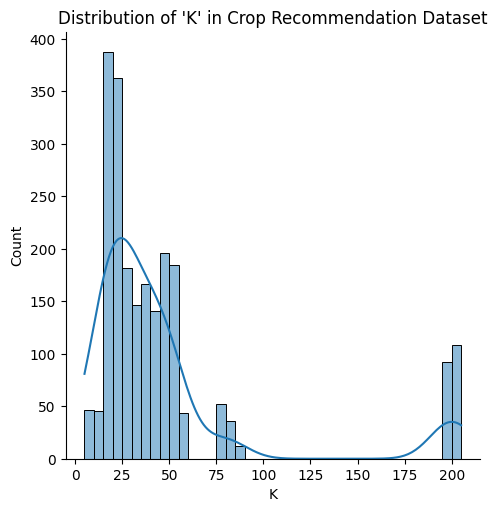

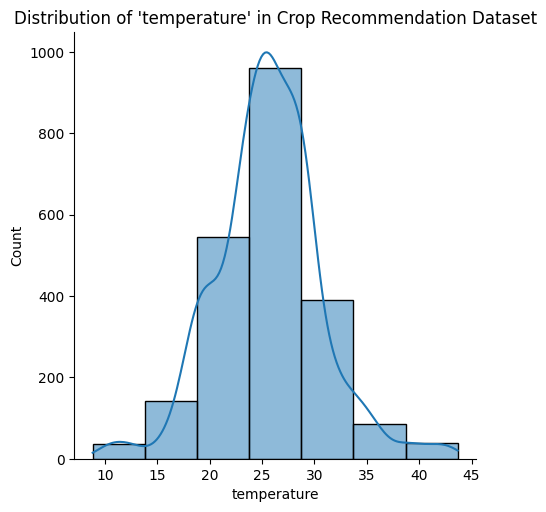

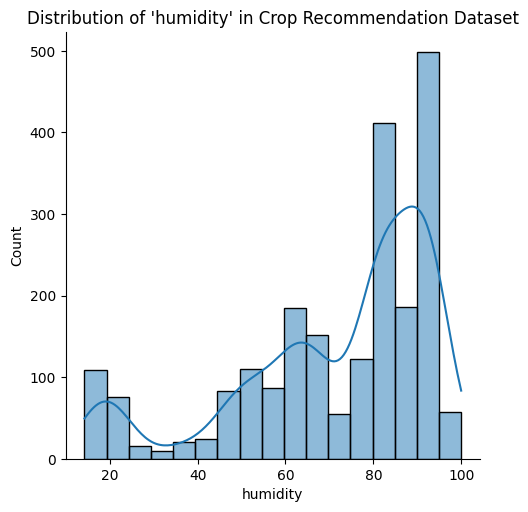

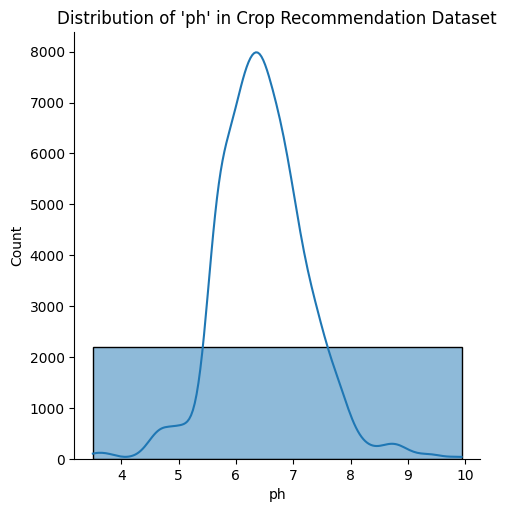

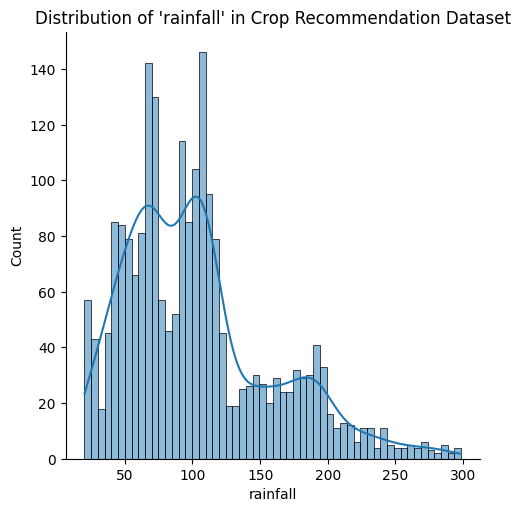

In [31]:
crop_numerical_features = crop_df.select_dtypes("number").columns.tolist()

for feature in crop_numerical_features:
    sns.displot(crop_df, x=feature, binwidth=5, kde=True)
    plt.title(f"Distribution of '{feature}' in Crop Recommendation Dataset")
    plt.show

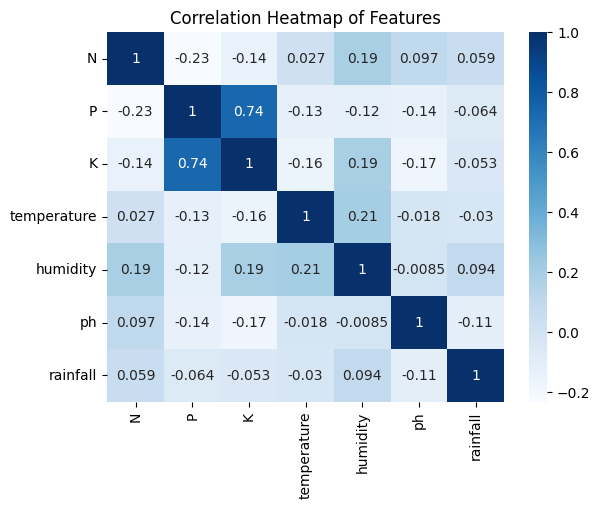

In [32]:
# Correlation heatmap for crop recommendation dataset

corr = crop_df.select_dtypes("number").corr()

sns.heatmap(
    corr,
    cmap="Blues",
    annot=True,
)
plt.title("Correlation Heatmap of Features")
plt.show()

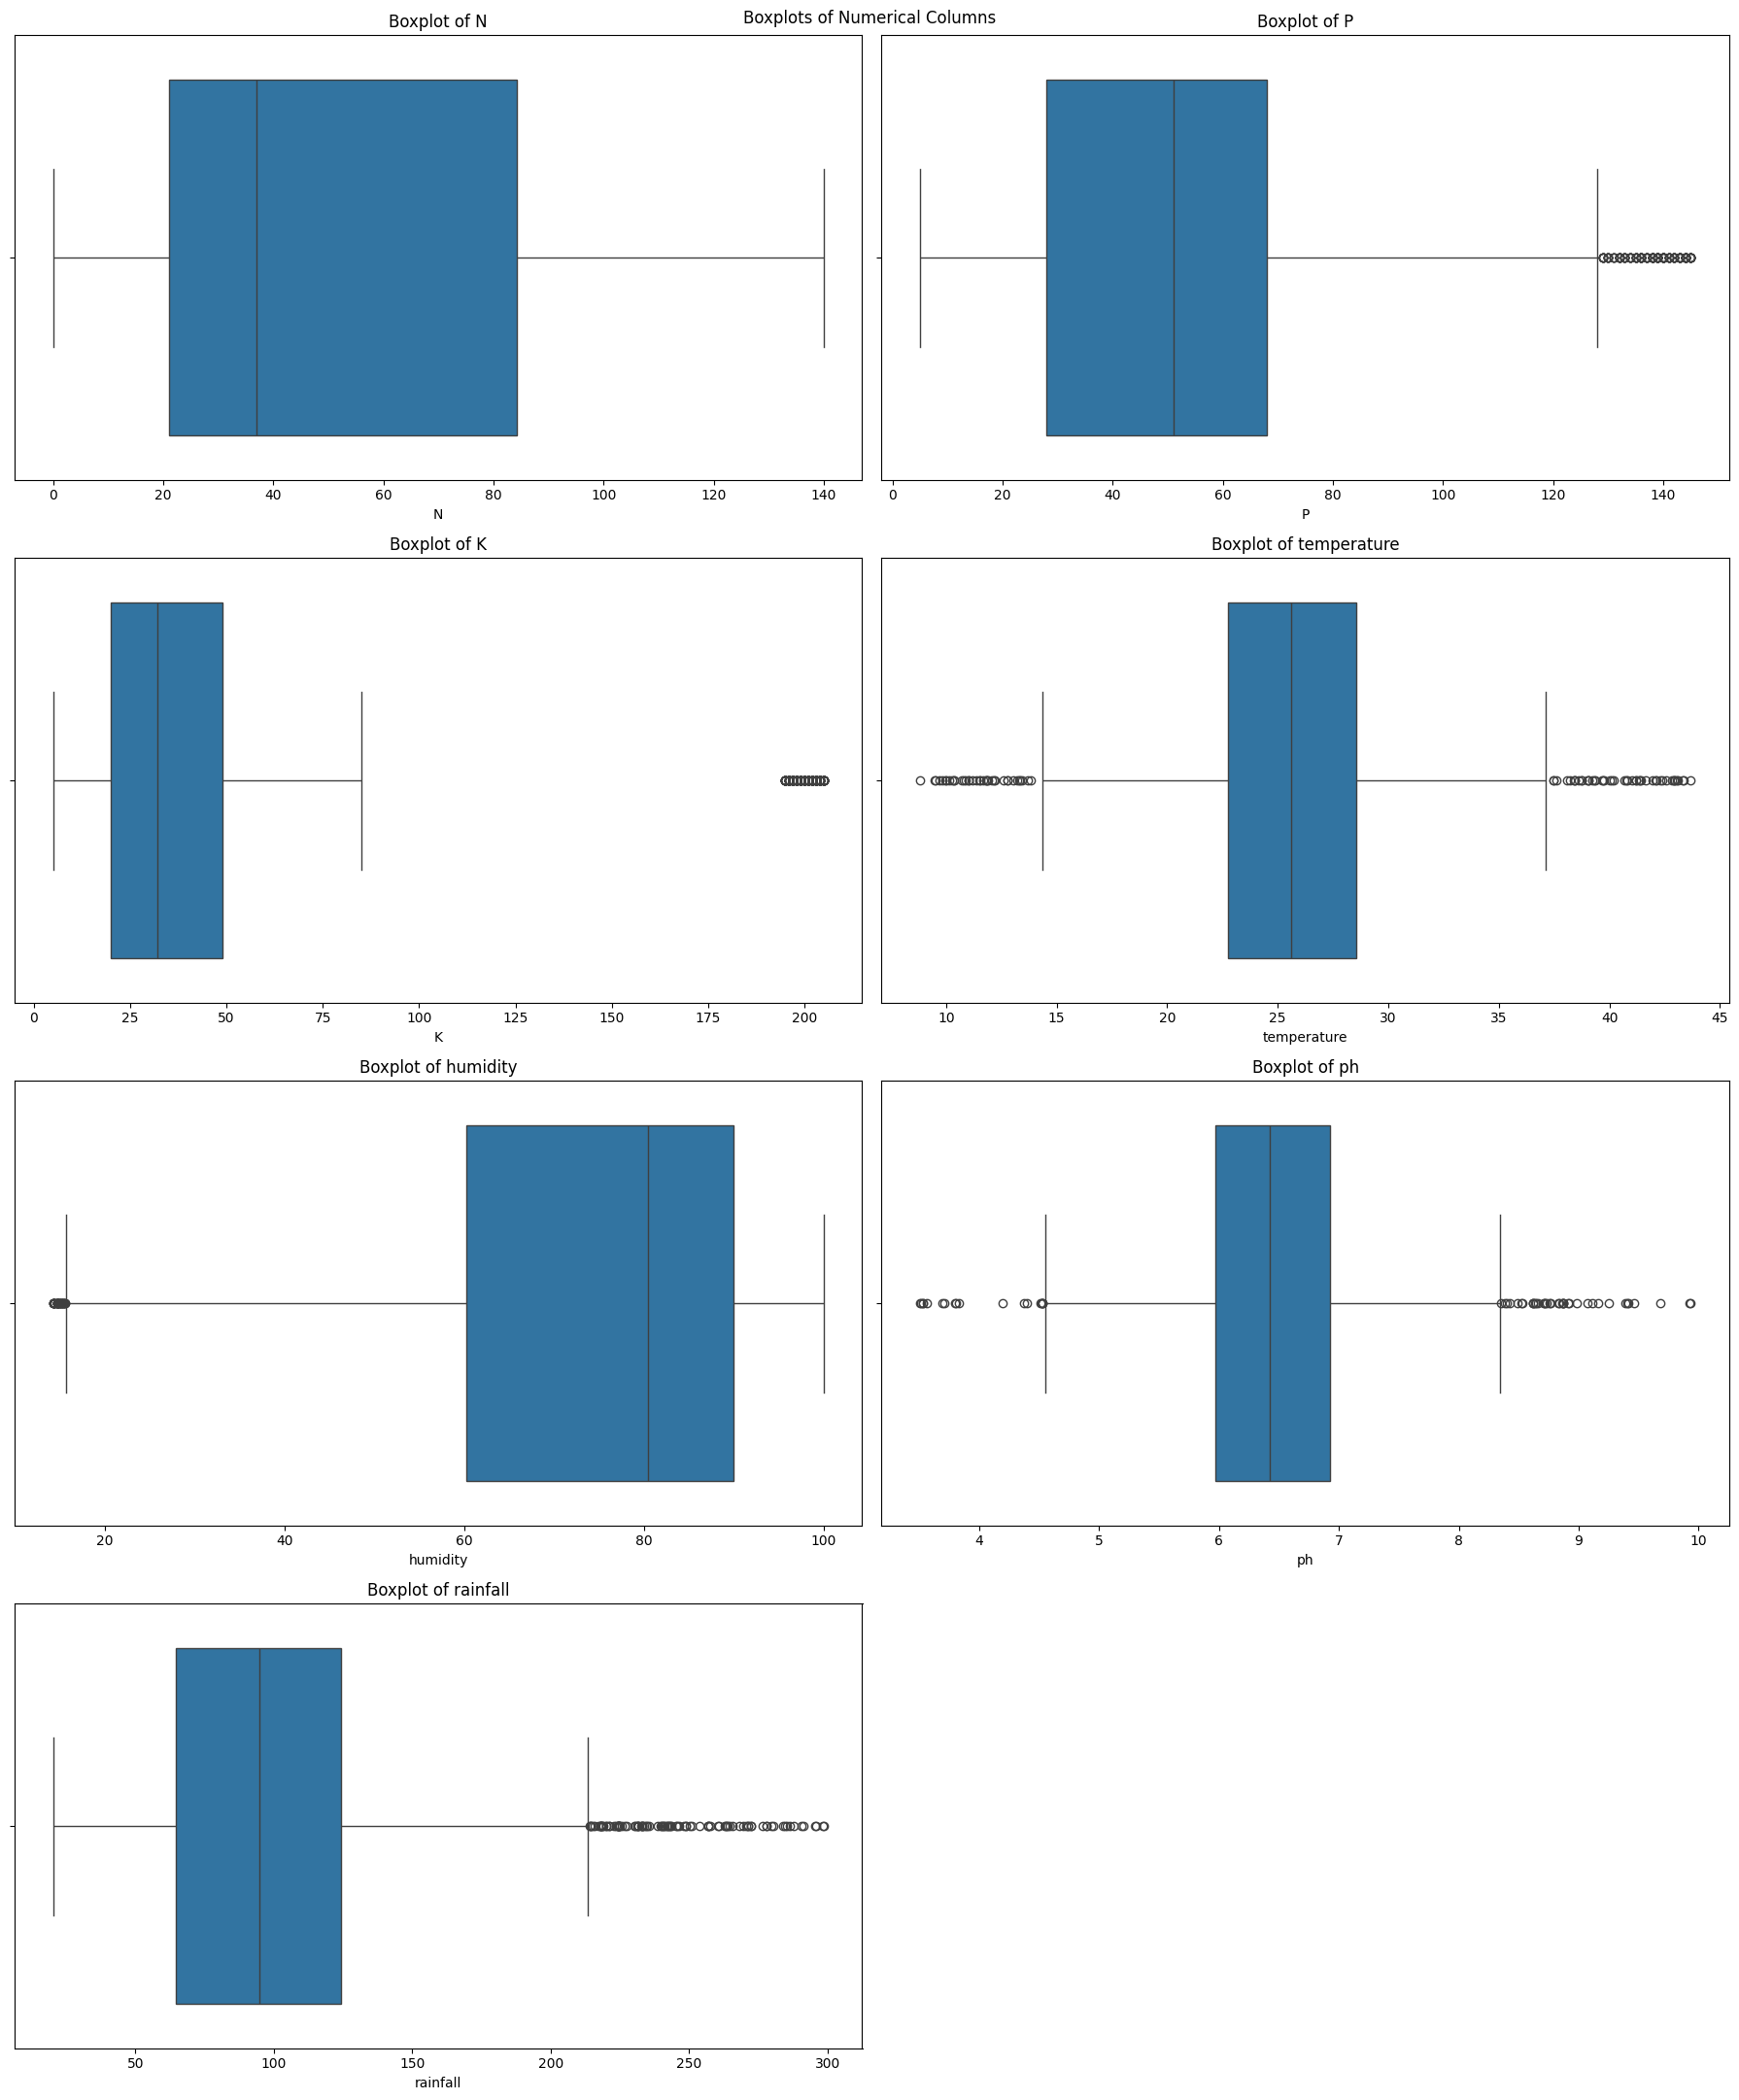

In [33]:
# Box plots for each numerical column
numerical_cols = crop_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
#print(f"\nNumerical columns for outlier analysis: {numerical_cols}")
plt.figure(figsize=(18,22))

for i, col in enumerate(numerical_cols):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=crop_df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.suptitle('Boxplots of Numerical Columns')
plt.tight_layout()
plt.show()

In [34]:
cols_with_outliers = []


def find_outliers_IQR(df: pd.DataFrame):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    outliers = df[((df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR)))]
    return outliers


for feature in crop_numerical_features:
    outliers = find_outliers_IQR(crop_df[feature])
    print(f"Number of outliers in '{feature}' column: {len(outliers)}")
    if len(outliers) != 0:
        cols_with_outliers.append(feature)

print(f"\nColumns with outliers: {cols_with_outliers}")

Number of outliers in 'N' column: 0
Number of outliers in 'P' column: 138
Number of outliers in 'K' column: 200
Number of outliers in 'temperature' column: 86
Number of outliers in 'humidity' column: 30
Number of outliers in 'ph' column: 57
Number of outliers in 'rainfall' column: 100

Columns with outliers: ['P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']


## Data Preprocessing

In [35]:
# Remove Outliers Using the IQR Method
Q1 = crop_df[numerical_cols].quantile(0.25)
Q3 = crop_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a mask for rows without outliers
mask = ~((crop_df[numerical_cols] < lower_bound) | (crop_df[numerical_cols] > upper_bound)).any(axis=1)

# Filter out rows with outliers
df_cleaned = crop_df[mask]
print(f"Original dataset size: {crop_df.shape}")
print(f"Dataset size after removing outliers: {df_cleaned.shape}")

Original dataset size: (2200, 8)
Dataset size after removing outliers: (1768, 8)


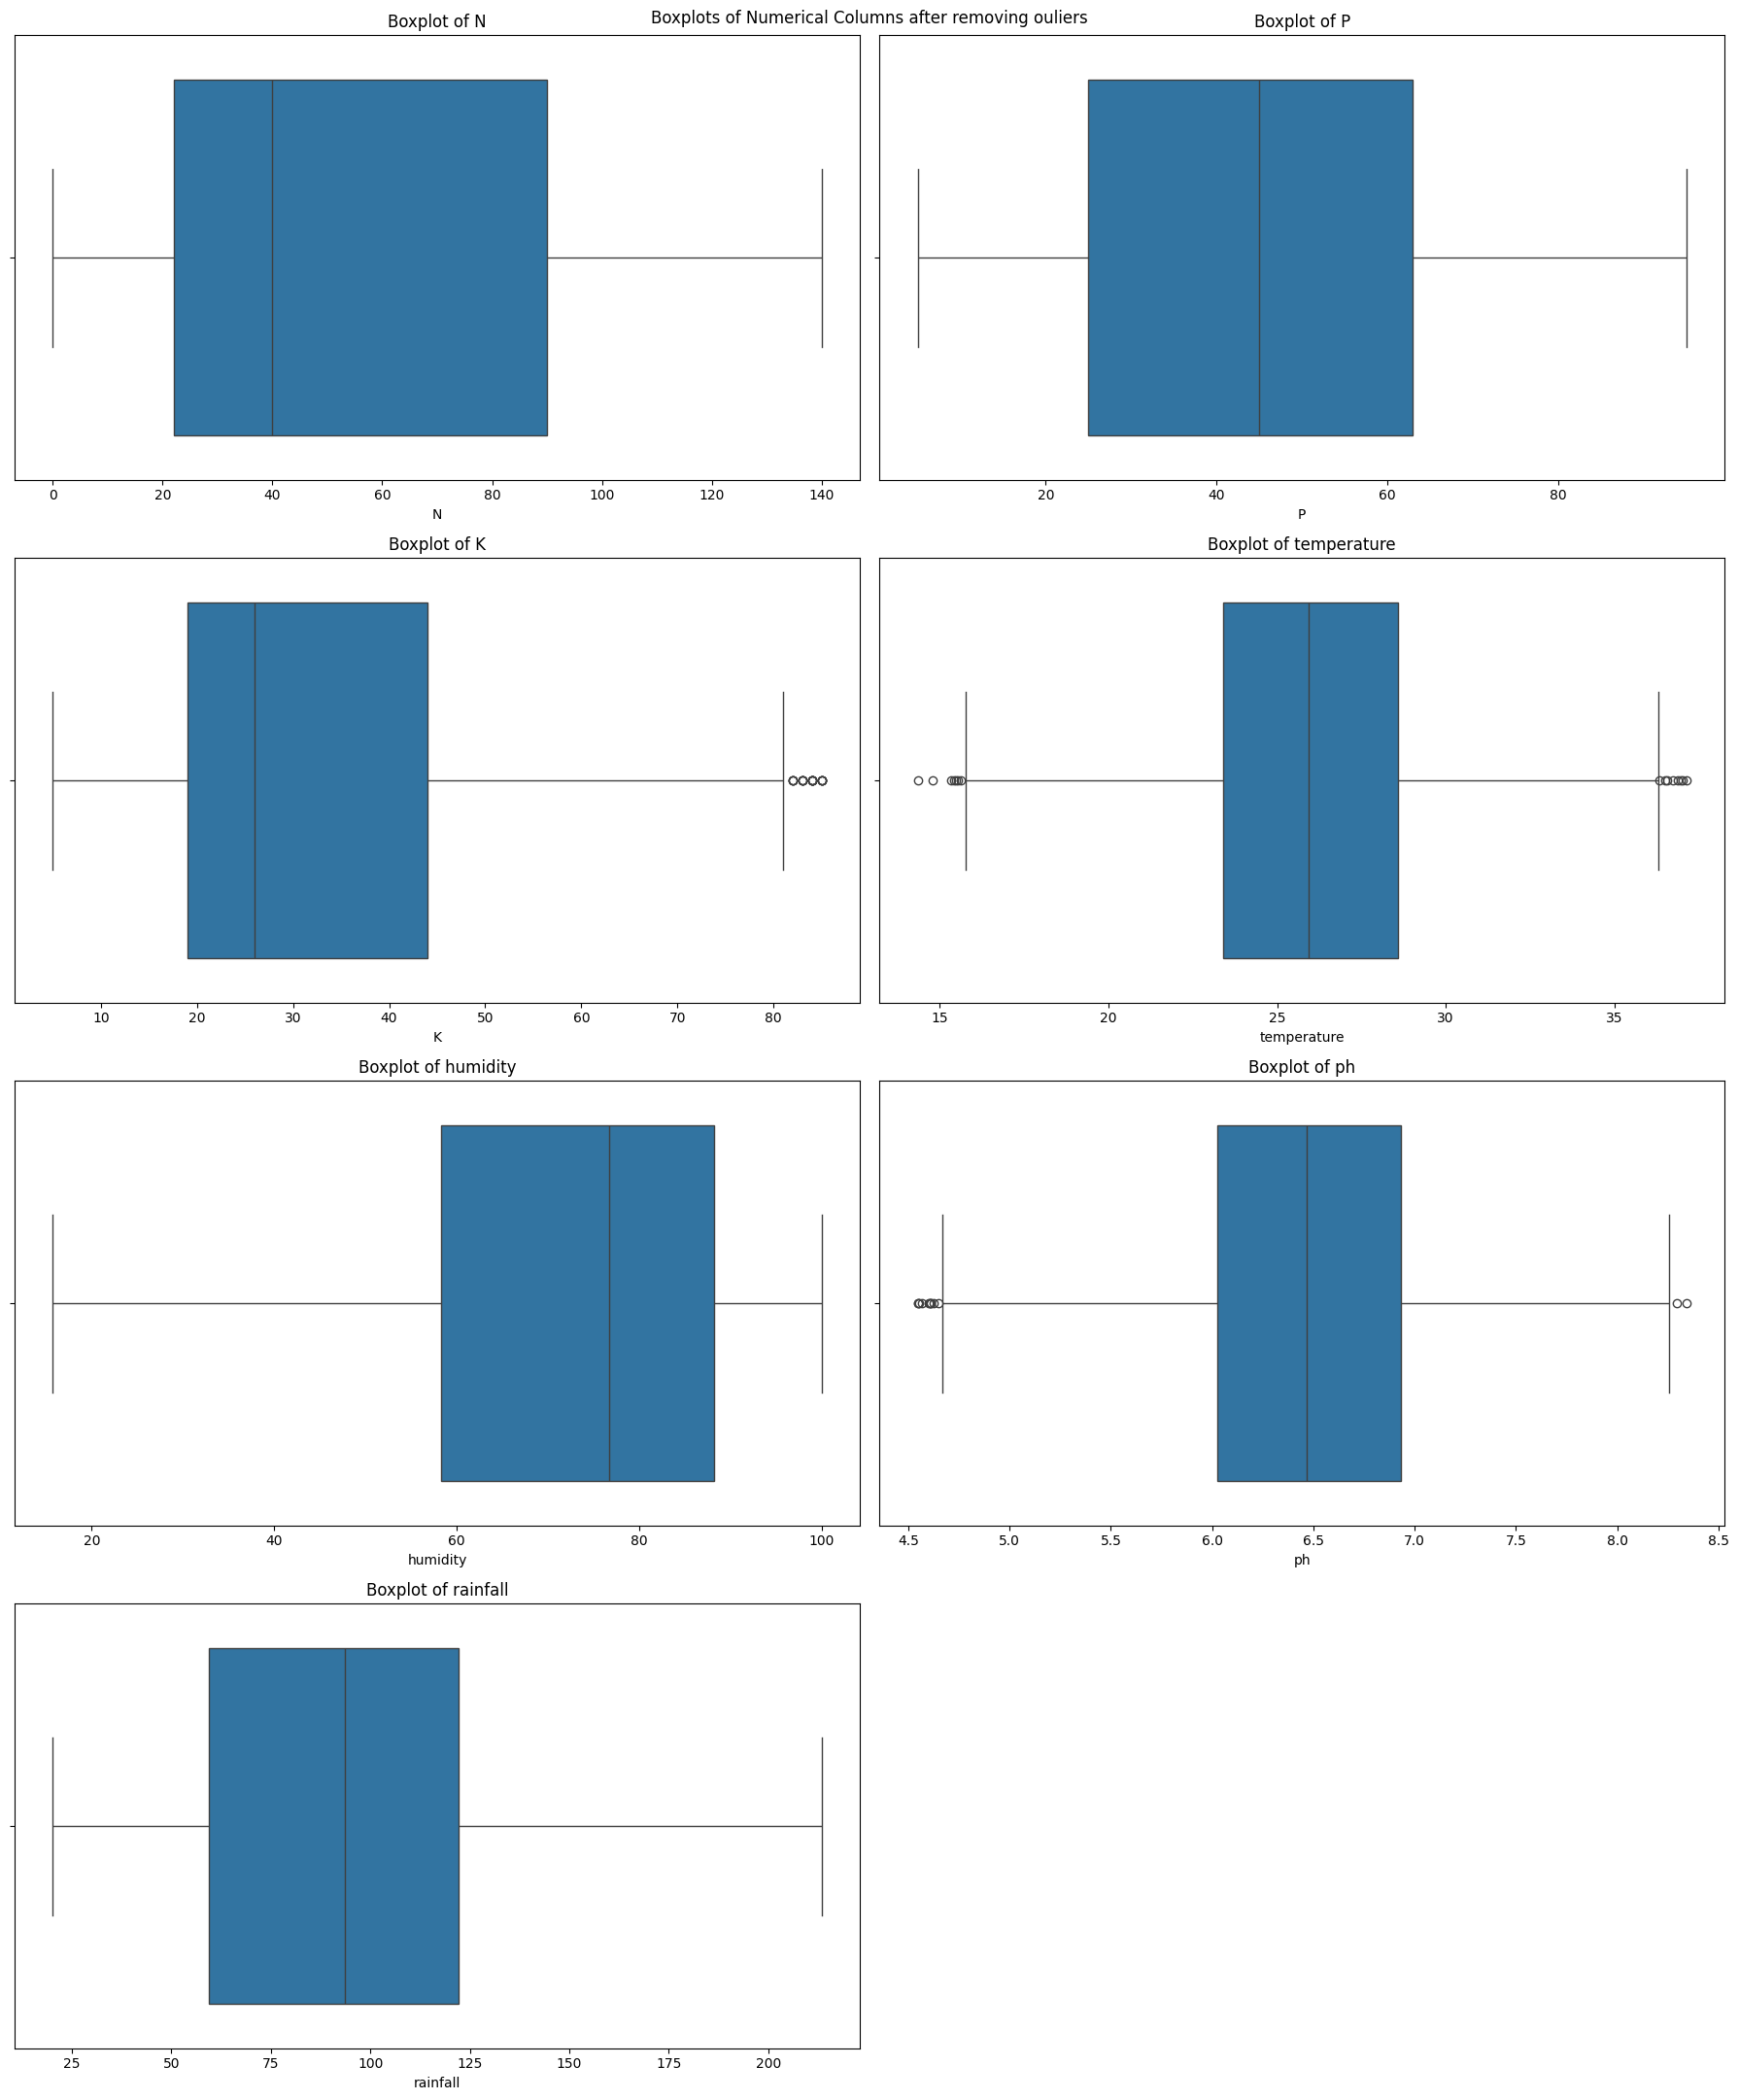

In [36]:
# Box plots for each numerical column after removing ouliers
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()
plt.figure(figsize=(18,22))

for i, col in enumerate(numerical_cols):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=df_cleaned[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.suptitle('Boxplots of Numerical Columns after removing ouliers')
plt.tight_layout()
plt.show()

In [37]:
# Encode labels

encoder = LabelEncoder()
crop_df["encoded_label"] = encoder.fit_transform(crop_df["label"])

crop_df.head(10)

,N,P,K,temperature,humidity,ph,rainfall,label,encoded_label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,20
5,69,37,42,23.058049,83.370118,7.073454,251.055000,rice,20
6,69,55,38,22.708838,82.639414,5.700806,271.324860,rice,20
7,94,53,40,20.277744,82.894086,5.718627,241.974195,rice,20
8,89,54,38,24.515881,83.535216,6.685346,230.446236,rice,20
9,68,58,38,23.223974,83.033227,6.336254,221.209196,rice,20


In [38]:
crop_df.tail(10)

,N,P,K,temperature,humidity,ph,rainfall,label,encoded_label
2190,103,40,30,27.309018,55.196224,6.348316,141.483164,coffee,5
2191,118,31,34,27.548230,62.881792,6.123796,181.417081,coffee,5
2192,106,21,35,25.627355,57.041511,7.428524,188.550654,coffee,5
2193,116,38,34,23.292503,50.045570,6.020947,183.468585,coffee,5
2194,97,35,26,24.914610,53.741447,6.334610,166.254931,coffee,5
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee,5
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee,5
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee,5
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee,5
2199,104,18,30,23.603016,60.396475,6.779833,140.937041,coffee,5


In [39]:
# Check original labels
labels = encoder.classes_

labels

array(['apple', 'banana', 'blackgram', 'chickpea', 'coconut', 'coffee',
       'cotton', 'grapes', 'jute', 'kidneybeans', 'lentil', 'maize',
       'mango', 'mothbeans', 'mungbean', 'muskmelon', 'orange', 'papaya',
       'pigeonpeas', 'pomegranate', 'rice', 'watermelon'], dtype=object)

In [40]:
# Split data for training and testing

features = crop_df[["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]]
target = crop_df["encoded_label"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=2
)

## Model Building, Training and Evaluation

In [41]:
# # Create dictionary of models {name: model_instance}
# models = {
#     "Logistic Regression": LogisticRegression(max_iter=1000),
#     "Naive Bayes": GaussianNB(),
#     "SVM": SVC(),
#     "Random Forest": RandomForestClassifier(),
#     "XGBoost": XGBClassifier(),
# }

# # Create dictionary to store trained models
# trained_models = {}

In [42]:
# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Evaluate logistic regression model
log_reg_pred = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        26
           2       0.96      0.89      0.93        28
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00        33
           6       0.94      0.94      0.94        31
           7       1.00      1.00      1.00        29
           8       0.89      0.94      0.91        33
           9       1.00      1.00      1.00        30
          10       0.94      1.00      0.97        32
          11       0.94      0.94      0.94        32
          12       1.00      1.00      1.00        33
          13       0.90      0.90      0.90        29
          14       1.00      1.00      1.00        32
          15       1.00      1.00      1.00        30
          16       1.00      1.00     

/home/ravindu-aratchige/Documents/KDU/Academics/Semester 7/Machine Learning - CS4042/Assignments/Group assignment/pohora.lk/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
# Train Support vector classifier
svm = SVC()
svm.fit(X_train, y_train)

# Evaluate Support vector classifier
svm_pred = svm.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, svm_pred))

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        26
           2       0.97      1.00      0.98        28
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00        33
           6       0.97      1.00      0.98        31
           7       1.00      1.00      1.00        29
           8       0.85      1.00      0.92        33
           9       0.91      1.00      0.95        30
          10       0.94      1.00      0.97        32
          11       1.00      0.97      0.98        32
          12       1.00      1.00      1.00        33
          13       1.00      0.90      0.95        29
          14       1.00      1.00      1.00        32
          15       1.00      1.00      1.00        30
          16       1.00      1.00      1.00        42


In [44]:
# Train Naive Bayes classifer
nb = GaussianNB()
nb.fit(X_train, y_train)

# Evaluate Naive Bayes classifer
nb_pred = nb.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_pred))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00        33
           6       1.00      1.00      1.00        31
           7       1.00      1.00      1.00        29
           8       0.89      0.97      0.93        33
           9       1.00      1.00      1.00        30
          10       1.00      1.00      1.00        32
          11       1.00      1.00      1.00        32
          12       1.00      1.00      1.00        33
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        32
          15       1.00      1.00      1.00        30
          16       1.00      1.00      1.00   

In [45]:
# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train, y_train)

# Evaluate Random Forest classifier
rf_pred = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00        33
           6       1.00      1.00      1.00        31
           7       1.00      1.00      1.00        29
           8       0.91      0.97      0.94        33
           9       1.00      1.00      1.00        30
          10       1.00      1.00      1.00        32
          11       1.00      1.00      1.00        32
          12       1.00      1.00      1.00        33
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        32
          15       1.00      1.00      1.00        30
          16       1.00      1.00      1.00 

In [46]:
# Train
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# Evaluate
xgb_pred = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00        33
           6       1.00      1.00      1.00        31
           7       1.00      1.00      1.00        29
           8       0.97      1.00      0.99        33
           9       1.00      1.00      1.00        30
          10       0.97      1.00      0.98        32
          11       1.00      1.00      1.00        32
          12       1.00      1.00      1.00        33
          13       1.00      0.97      0.98        29
          14       1.00      1.00      1.00        32
          15       1.00      1.00      1.00        30
          16       1.00      1.00      1.00       

In [47]:
# Store trained model instances in dict
trained_models = {
    "Logistic Regression": log_reg,
    "Naive Bayes": nb,
    "SVM": svm,
    "Random Forest": rf,
}

In [66]:
# Perform inference on model to verify it

sample_row = crop_df.iloc[[2]]
sample_row_features = selected_row.drop(columns=["label", "encoded_label"])

sample_prediction = encoder.inverse_transform(rf.predict(sample_row_features))[0]
sample_actual = str(sample_row.iloc[0]["label"])

print(f"Predicted label: {sample_prediction}")
print(f"Actual label: {sample_actual}")

Predicted label: rice
Actual label: rice


In [49]:
# Create a directory to store models if it doesn't exist
os.makedirs("../models", exist_ok=True)

In [67]:
# Save each model with proper naming
for model_name, model in trained_models.items():
    # Remove spaces from filename
    filename = f"../models/{model_name.replace(' ', '_').lower()}.pkl"
    joblib.dump(model, filename)
    print(f"Saved {model_name} to {filename}")

Saved Logistic Regression to ../models/logistic_regression.pkl
Saved Naive Bayes to ../models/naive_bayes.pkl
Saved SVM to ../models/svm.pkl
Saved Random Forest to ../models/random_forest.pkl
